# Style Transfer

### using gram matrix (feature activation co-variance)

### the Gram matrix is defined as: $G = M^T M$
### it uses the features for the activation maps (features from the convolutional layers)
### pre-trained networks are regularly used for style transfer

### First it matches the source image with a random image, then it uses the Gram matrix of the random image as target.

## Two stages of the algoritm: Preparation and Training

### Preparation:
### - Import and freeze a pre-trained CNN
### - Import and transform images
### - Make a trainable target image using random numbers 
### - Functions to compute the feature maps and gram matrices
### Training:
### - Extract feature activation maps
### - contentMSE: target vs content
###     - Compute Gram matrix of target feature maps
###     - styleMSE of targetgram vs stylegram
### - Loss is defined as contentMSE + styleMSE
### - Backprop on Target image

In [2]:
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import sklearn.metrics as skm
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torch
from torchsummary import summary
import time
import os
import copy
import numpy as np

#importing convolution from scipy
from scipy.signal import convolve2d

from imageio import imread

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


# defining device as cuda (to use gpus for training)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# We are going to use a known architecture (vgg-19) that has been already trained

In [4]:
# importing the vgg19 model
vggnet = torchvision.models.vgg19(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

# We need to lock the parameters so they don't move when evaluating and copying the style

In [5]:
for p in vggnet.parameters():
    p.requires_grad = False

vggnet.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Move model to GPU

In [6]:
vggnet.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Now we import the images we want to use (original and reference)

In [7]:
#importing images 
img4content = imread(
    'https://raw.githubusercontent.com/spiralizing/CVResume/main/Resume/Mypic.jpeg')
img4style = imread('http://oregoneclipse2017.com/wp-content/uploads/2017/08/allyson-grey.jpg')


# Creating a new image generated with random numbers, we are going to modify this image so it 'looks like' both images we uploaded

In [8]:
#initialize the target image with random numbers

img4target = np.random.randint(low=0, high=255, size= img4content.shape, dtype=np.uint8)
#checking sizes

print(img4content.shape)
print(img4style.shape)
print(img4target.shape)

(431, 431, 3)
(1600, 1603, 3)
(431, 431, 3)


# Defining transformations to preprocess the images and get them ready to use them with pytorch

In [9]:
#re-sizing the images so it takes less time to train
Trans = T.Compose(
    [T.ToTensor(), 
    T.Resize(256), 
    T.Normalize([0.485, 0.456, 0.406], [0.229,0.224,0.225])]
)

#unsqueeze the images to make them a 4D tensor
img4content = Trans( img4content ).unsqueeze(0).to(device)
img4style = Trans( img4style ).unsqueeze(0).to(device)
img4target = Trans( img4target ).unsqueeze(0).to(device)

#check shapes [n_batch, channels, px_y, px_x]
print(img4content.shape)
print(img4style.shape)
print(img4target.shape)


torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


# Now that everything is in order let's take a look at the images we are going to be working with

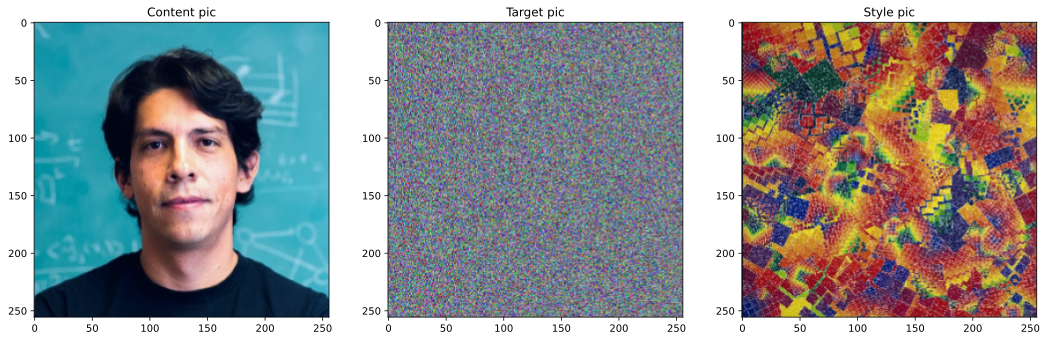

In [10]:
#take a look at the images 
fig, ax = plt.subplots(1,3, figsize=(18,6))

tites = ['Content pic', 'Target pic', 'Style pic']

for i, pic in enumerate([img4content, img4target, img4style]):
    img = pic.cpu().squeeze().numpy().transpose((1,2,0)) #transform for display
    img = (img - np.min(img)) / (np.max(img)-np.min(img)) #undo normalization
    ax[i].imshow(img)
    ax[i].set_title(tites[i])

# Now we define some functions to extract the activation maps and compute the covariance matrix

In [11]:
#we define a function to extract the feature act maps
def get_feat_actmaps(img, net):
    feature_maps = []
    feature_names = []

    convL_ix = 0 #counter init

    #loop over the layers in the features block
    for lay_num in range(len(net.features)):
        #print(lay_num, net.features[lay_num])
        #process the image through this layer
        img = net.features[lay_num](img)
        #store the results that come from the convolutions
        if 'Conv2d' in str(net.features[lay_num]):
            feature_maps.append( img )
            feature_names.append('ConvLayer_' + str(convL_ix))
            convL_ix += 1
        
    return feature_maps, feature_names

def get_gramMat(M):
    #reshaping to 2D
    _,chans,height,width = M.shape
    M = M.reshape(chans, height*width) 

    #compute covariance matrix
    gram = torch.mm(M, M.t()) / (chans*height*width)

    return gram

# Extract the activation maps in the layers

In [12]:
#try the feature maps function

content_fm, content_fn = get_feat_actmaps(img4content, vggnet)

# Plotting the content of the layers and their covariance matrix

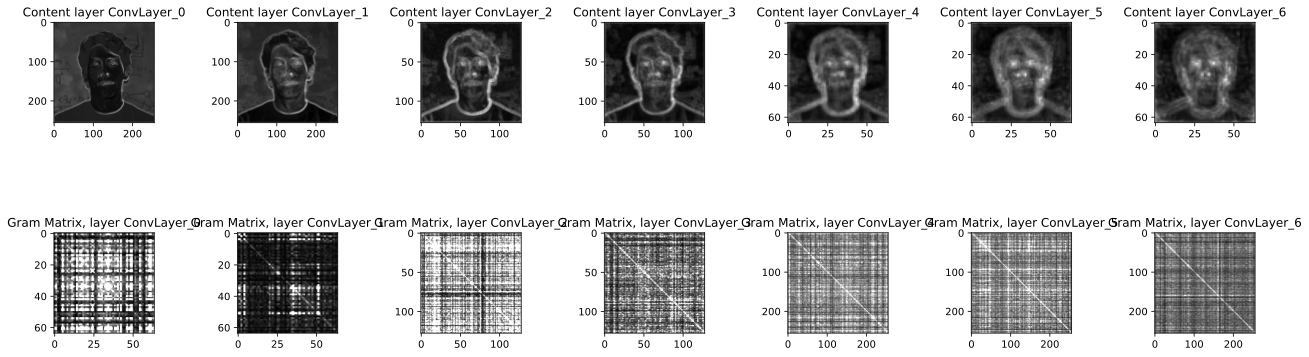

In [13]:
fig, axs = plt.subplots(2,7, figsize=(18,6))

for i in range(7):
    img = np.mean( content_fm[i].cpu().squeeze().numpy(), axis=0)
    img = (img - np.min(img))/(np.max(img) - np.min(img))

    axs[0,i].imshow(img, cmap='gray')
    axs[0,i].set_title('Content layer '+ str(content_fn[i]))

    #the gram matrix:
    img = get_gramMat(content_fm[i]).cpu().numpy()
    img = (img - np.min(img))/(np.max(img)-np.min(img))

    axs[1,i].imshow(img, cmap='gray',vmax=0.1)
    axs[1,i].set_title('Gram Matrix, layer '+ str(content_fn[i]))

plt.tight_layout()
plt.show()

# Doing the same for the image reference

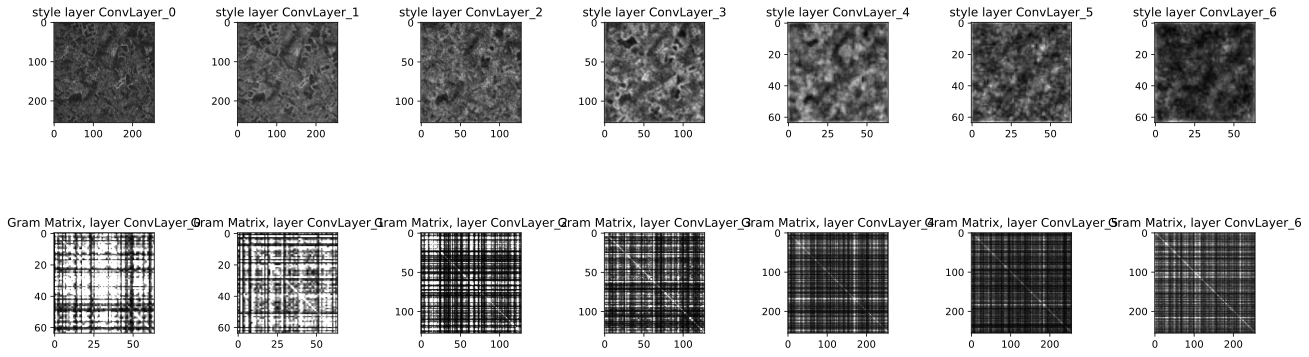

In [14]:
#style image
style_fm, style_fn = get_feat_actmaps(img4style, vggnet)

fig, axs = plt.subplots(2, 7, figsize=(18, 6))

for i in range(7):
    img = np.mean(style_fm[i].cpu().squeeze().numpy(), axis=0)
    img = (img - np.min(img))/(np.max(img) - np.min(img))

    axs[0, i].imshow(img, cmap='gray')
    axs[0, i].set_title('style layer ' + str(style_fn[i]))

    #the gram matrix:
    img = get_gramMat(style_fm[i]).cpu().numpy()
    img = (img - np.min(img))/(np.max(img)-np.min(img))

    axs[1, i].imshow(img, cmap='gray', vmax=0.1)
    axs[1, i].set_title('Gram Matrix, layer ' + str(style_fn[i]))

plt.tight_layout()
plt.show()


# We are going to use only some of the matrices (layers) for the original and reference image
# Adding a linear combination of the matrices for the image of reference

In [15]:
#defining parameters
#Layers from the CNN that are going to be used to transfer style
layers_content = ['ConvLayer_1', 'ConvLayer_2'] #2 layers from content
layers_style = ['ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4','ConvLayer_5']
weights_style = [1, 0.5, 0.5, 0.2 ,0.1] #how much weight to give to each style layer

# Now we are going to define our new image (matrix) as the parameter to optimize
### Send the matrix to GPU

In [16]:
target = img4target.clone()
target.requires_grad = True
target = target.to(device)
style_scale = 1e5 #scale up the lossfunction for the style

n_epochs = 2500

optimizer = torch.optim.RMSprop([target], lr=0.005)

# Minimize the combined loss (RMS between matrices) to obtain a resulting image that resemble of both pictures (original and reference)

### We define a 'content loss' as the RMS between the original image and the new one
### We define a 'style loss' as the RMS between the gram matrices from the reference image to the new one

In [17]:
for e_i in range(n_epochs):
    target_fm, target_fn = get_feat_actmaps(target, vggnet)

    style_loss = 0
    content_loss = 0

    for layer_i in range(len(target_fn)):
        #using only the layers specified previously

        #content loss
        if target_fn[layer_i] in layers_content:
            content_loss += torch.mean(( target_fm[layer_i] - content_fm[layer_i])**2)
        
        #style loss
        if target_fn[layer_i] in layers_style:
            #computing gram Matrices
            Gtarget = get_gramMat(target_fm[layer_i])
            Gstyle = get_gramMat(style_fm[layer_i])

            #compute loss with weights
            style_loss += torch.mean( (Gtarget - Gstyle)**2 ) * weights_style[layers_style.index(target_fn[layer_i])]

    #computing combined loss (re-scaled style loss + content loss)
    comb_loss = style_scale*style_loss + content_loss

    #backprop
    optimizer.zero_grad()
    comb_loss.backward()
    optimizer.step()

# Visualizing the results

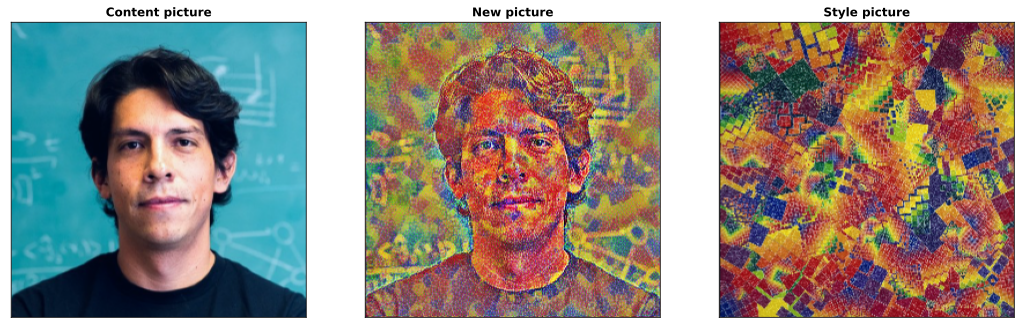

In [18]:
# the final result
fig, ax = plt.subplots(1, 3, figsize=(18, 11))

pic = img4content.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture', fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach(
).squeeze().numpy().transpose((1, 2, 0))
ax[1].imshow(pic)
ax[1].set_title('New picture', fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture', fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()
